# SMS Classifier

## Introduction

Develop a text classification model to classify SMS as either spam or non-spam using data science techniques in Python. The algorithms that will be used in this project are: 
1. GaussianNB
2. MultinomialNB
3. DecisionTreeClassifier
4. RandomForestClassifier
5. Support Vector Classifier

## Data

The dataset used for this project contains two columns namely:
1. `text`: This column contains the email received
2. `spam`: This column marks an email as spam or not spam. Where 0 = not spam and 1 = spam





In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Functions to Plot the classification report
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification Report', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        # print(v)
        plotMat.append(v)

    # print('plotMat: {0}'.format(plotMat))
    # print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


In [3]:

df=pd.read_csv('emails.csv')
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


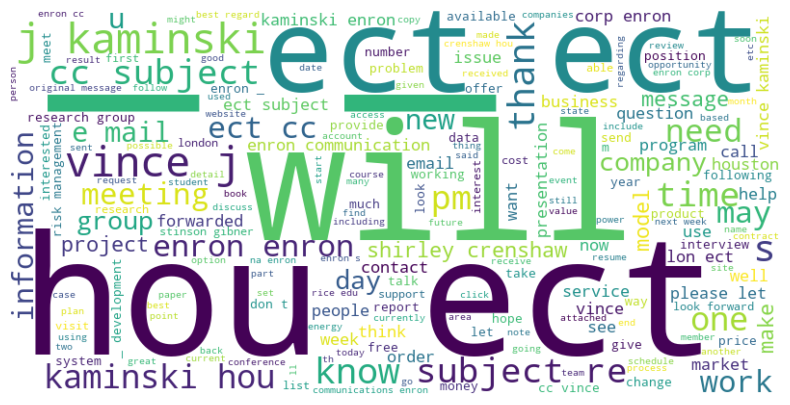

In [4]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df['text']))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Axes: xlabel='spam', ylabel='count'>

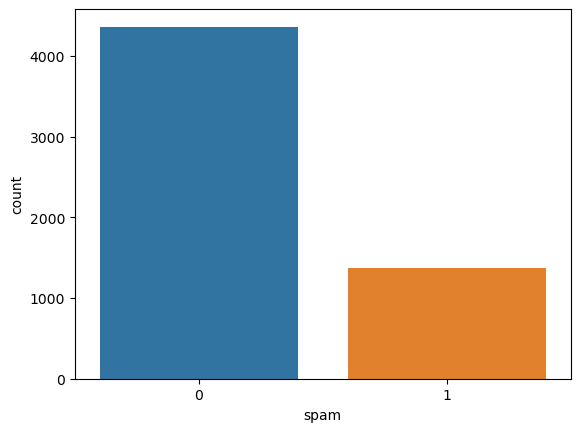

In [5]:
sns.countplot(x = df["spam"], data = df)

**Observation:** Seems like this dataset is inbalanced

In [6]:
df.spam.value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [7]:
df.spam.value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [8]:
from sklearn.utils import resample

# create two different dataframe of majority and minority class 

df_majority = df[df['text'] == 0] 

df_minority = df[df['text'] == 1] 

# upsample minority class
df_minority_upsampled = resample(df_minority, replace = True, random_state = 42) 

# reproducible results
    
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [9]:
df_upsampled.isnull().sum()

text    0.0
spam    0.0
dtype: float64

In [10]:
# Remove the stop words and transform the texts into the vectorized input variables X
vectorizer = CountVectorizer(stop_words='english')

X = vectorizer.fit_transform(df["text"])

y = df["spam"]

# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.3, random_state=0)

# Build Models

In [11]:
target_names=['Not Spam','Spam']

### GNB Model

Accuracy Score: 5.234679698944092


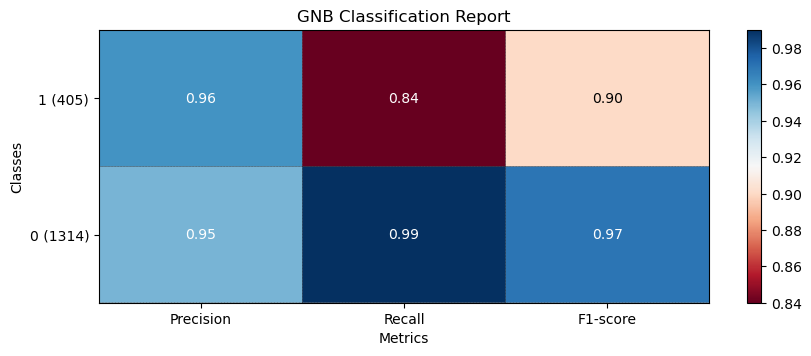

In [12]:
start_time = time.time()

gnb_clf = GaussianNB()

gnb_clf.fit(X_train, y_train)

gnb_time = time.time() - start_time

gnb_acc = round(gnb_clf.score(X_test, y_test), 4)

print(f'Accuracy Score: {gnb_time}')

gnb_cr = classification_report(y_test, gnb_clf.predict(X_test))
plot_classification_report(gnb_cr, title = 'GNB Classification Report')

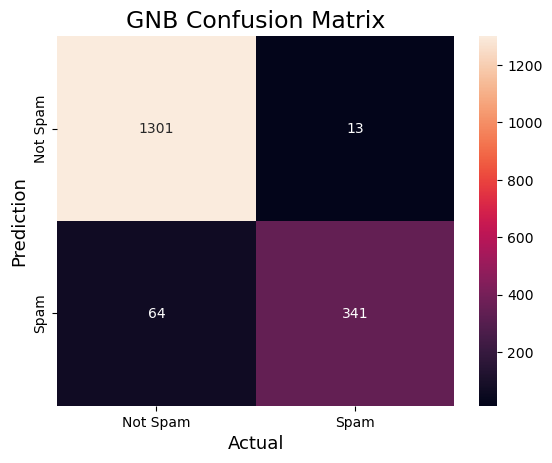

In [13]:
gnb_cm = confusion_matrix(y_test, gnb_clf.predict(X_test))

sns.heatmap(
    gnb_cm,
    annot = True,
    fmt = 'g',
    xticklabels= target_names,
    yticklabels= target_names
)
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('Actual', fontsize = 13)
plt.title('GNB Confusion Matrix', fontsize = 17);

### MNB Model

Accuracy Score: 0.9878


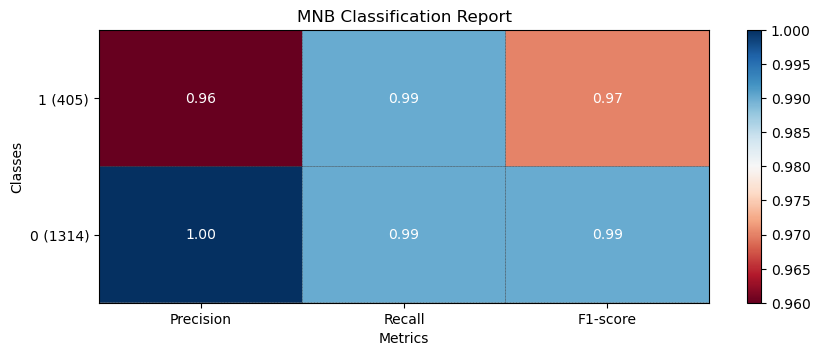

In [14]:
start_time = time.time()

mnb_clf = MultinomialNB()

mnb_clf.fit(X_train, y_train) # fit model

mnb_time = time.time() - start_time # calculate time taken to train and fit

mnb_acc = round(mnb_clf.score(X_test, y_test), 4)

print(f'Accuracy Score: {mnb_acc}')

mnb_cr = classification_report(y_test, mnb_clf.predict(X_test))
plot_classification_report(mnb_cr, title = 'MNB Classification Report')

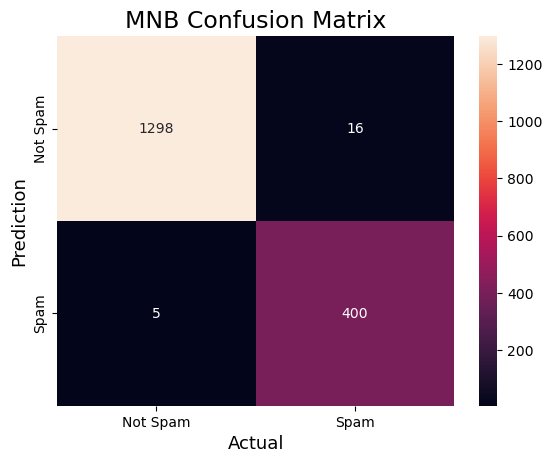

In [15]:
mnb_cm = confusion_matrix(y_test, mnb_clf.predict(X_test))

sns.heatmap(
    mnb_cm,
    annot = True,
    fmt = 'g',
    xticklabels= target_names,
    yticklabels= target_names
)
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('Actual', fontsize = 13)
plt.title('MNB Confusion Matrix', fontsize = 17);

### DTC Model

Accuracy Score: 0.954


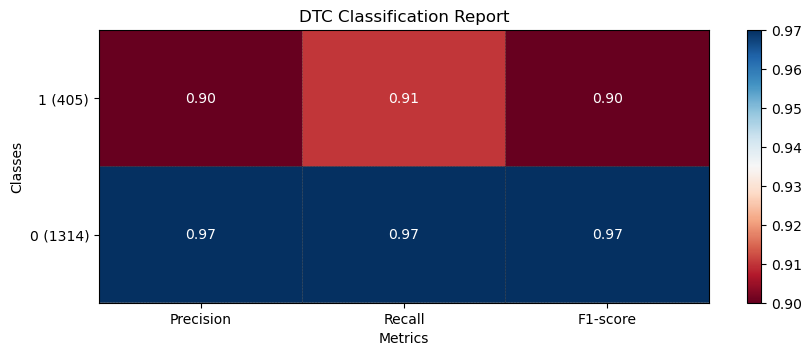

In [16]:
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()

dtc_clf = DecisionTreeClassifier()

dtc_clf.fit(X_train, y_train)

dtc_time = time.time() - start_time # calculate time taken to train and fit

dtc_acc = round(dtc_clf.score(X_test, y_test), 4)
print(f'Accuracy Score: {dtc_acc}')

dtc_cr = classification_report(y_test, dtc_clf.predict(X_test))
plot_classification_report(dtc_cr, title = 'DTC Classification Report')

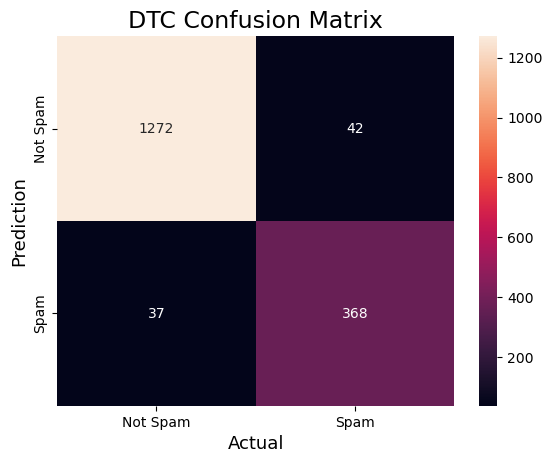

In [17]:
dtc_cm = confusion_matrix(y_test, dtc_clf.predict(X_test))

sns.heatmap(
    dtc_cm,
    annot = True,
    fmt = 'g',
    xticklabels= target_names,
    yticklabels= target_names
)
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('Actual', fontsize = 13)
plt.title('DTC Confusion Matrix', fontsize = 17);

### RFC Model

Accuracy Score: 0.9756


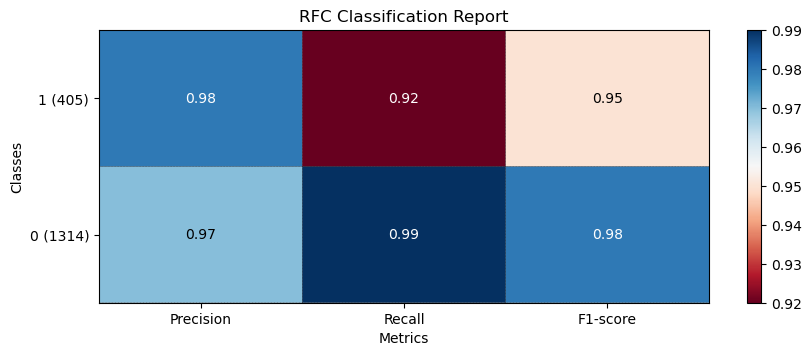

In [18]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()

rfc_clf = RandomForestClassifier()

rfc_clf.fit(X_train, y_train)

rfc_time = time.time() - start_time # calculate time taken to train and fit

rfc_acc = round(rfc_clf.score(X_test, y_test), 4)
print(f'Accuracy Score: {rfc_acc}')

rfc_cr = classification_report(y_test, rfc_clf.predict(X_test))
plot_classification_report(rfc_cr, title = 'RFC Classification Report')

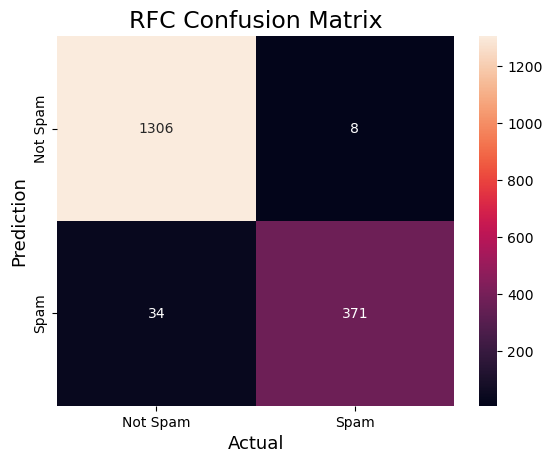

In [19]:
rfc_cm = confusion_matrix(y_test, rfc_clf.predict(X_test))

sns.heatmap(
    rfc_cm,
    annot = True,
    fmt = 'g',
    xticklabels= target_names,
    yticklabels= target_names
)
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('Actual', fontsize = 13)
plt.title('RFC Confusion Matrix', fontsize = 17);

### SVC Model

In [20]:
from sklearn.svm import SVC

start_time = time.time()

svc_clf = SVC()

svc_clf.fit(X_train, y_train)

svc_time = time.time() - start_time # calculate time taken to train and fit

svc_acc = round(svc_clf.score(X_test, y_test), 4)
print(f'Accuracy Score: {svc_acc}')

# svc_cr = classification_report(y_test, svc_clf.predict(X_test))
# plot_classification_report(svc_cr, title = 'SVC Classification Report')

Accuracy Score: 0.9721


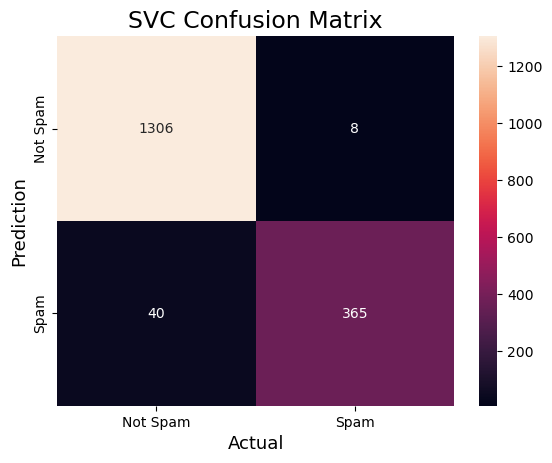

In [21]:
svc_cm = confusion_matrix(y_test, svc_clf.predict(X_test))

sns.heatmap(
    svc_cm,
    annot = True,
    fmt = 'g',
    xticklabels= target_names,
    yticklabels= target_names
)
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('Actual', fontsize = 13)
plt.title('SVC Confusion Matrix', fontsize = 17);

In [25]:
clf_ls = ['GNB', 'MNB', 'DTC', 'RFC','SVC']
clf_acc = [gnb_acc, mnb_acc, dtc_acc, rfc_acc, svc_acc]
time_taken = [gnb_time, mnb_time, dtc_time, rfc_time, svc_time]
dict_clf = {'model': clf_ls, 
            'accuracy':clf_acc, 
            'time taken in seconds(train & fit)':time_taken
            }

In [26]:
pd.DataFrame(dict_clf)

,model,accuracy,time taken in seconds(train & fit)
0,GNB,0.9552,5.234680
1,MNB,0.9878,9.466484
2,DTC,0.9540,69.191898
3,RFC,0.9756,92.541813
4,SVC,0.9721,189.787502


__Model Ranking Based on Performance__
1. MultinomialNB
2. GaussianNB
3. DecisionTreeClassifier
4. RandomForestClassifier
5. Support Vector Classifier